# Simple GAN on ART

## Dataset Loading

In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [3]:
dataset = datasets.ImageFolder(root=r"..\data\images", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

## Model definition

In [3]:
import torch.nn as nn

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Model Training

In [9]:
num_epochs = 50
real_label = 1
fake_label = 0

In [10]:
G_losses = []
D_losses = []

In [12]:
from tqdm import tqdm

for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader, 0)):
        # Update Discriminator with real images
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        # Update Discriminator with fake images
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()
        
        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()                                                    
        optimizerG.step()
        
        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD_real.item() + errD_fake.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {errD_real.item() + errD_fake.item()}, loss G: {errG.item()}")

100%|██████████| 132/132 [02:30<00:00,  1.14s/it]


Epoch [1/50] Loss D: 0.281798854470253, loss G: 3.4596290588378906


100%|██████████| 132/132 [01:51<00:00,  1.18it/s]


Epoch [2/50] Loss D: 1.0169717073440552, loss G: 2.8845911026000977


100%|██████████| 132/132 [01:53<00:00,  1.16it/s]


Epoch [3/50] Loss D: 0.7591289579868317, loss G: 1.7767727375030518


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]


Epoch [4/50] Loss D: 0.4931066110730171, loss G: 4.136396884918213


100%|██████████| 132/132 [02:00<00:00,  1.10it/s]


Epoch [5/50] Loss D: 0.5842848122119904, loss G: 2.962649345397949


100%|██████████| 132/132 [02:00<00:00,  1.10it/s]


Epoch [6/50] Loss D: 0.8318152129650116, loss G: 3.170682191848755


100%|██████████| 132/132 [02:01<00:00,  1.08it/s]


Epoch [7/50] Loss D: 0.46517951786518097, loss G: 3.131723642349243


100%|██████████| 132/132 [02:07<00:00,  1.04it/s]


Epoch [8/50] Loss D: 0.6837884187698364, loss G: 3.942377805709839


100%|██████████| 132/132 [02:17<00:00,  1.04s/it]


Epoch [9/50] Loss D: 0.9363222122192383, loss G: 1.132582187652588


100%|██████████| 132/132 [02:02<00:00,  1.08it/s]


Epoch [10/50] Loss D: 1.0542161464691162, loss G: 3.531870126724243


100%|██████████| 132/132 [02:06<00:00,  1.05it/s]


Epoch [11/50] Loss D: 1.6344697931781411, loss G: 2.740170478820801


100%|██████████| 132/132 [02:00<00:00,  1.09it/s]


Epoch [12/50] Loss D: 0.7474339455366135, loss G: 3.877650737762451


100%|██████████| 132/132 [01:59<00:00,  1.10it/s]


Epoch [13/50] Loss D: 0.42267122864723206, loss G: 3.0592057704925537


100%|██████████| 132/132 [01:59<00:00,  1.10it/s]


Epoch [14/50] Loss D: 0.5264825746417046, loss G: 3.1813035011291504


100%|██████████| 132/132 [01:59<00:00,  1.10it/s]


Epoch [15/50] Loss D: 1.0110349655151367, loss G: 3.399275064468384


100%|██████████| 132/132 [02:02<00:00,  1.08it/s]


Epoch [16/50] Loss D: 0.2681713253259659, loss G: 3.6416409015655518


100%|██████████| 132/132 [02:01<00:00,  1.08it/s]


Epoch [17/50] Loss D: 0.43943076953291893, loss G: 2.572687864303589


100%|██████████| 132/132 [02:10<00:00,  1.01it/s]


Epoch [18/50] Loss D: 0.8456623256206512, loss G: 2.6331639289855957


100%|██████████| 132/132 [02:03<00:00,  1.07it/s]


Epoch [19/50] Loss D: 0.4755033031105995, loss G: 2.8680124282836914


100%|██████████| 132/132 [02:06<00:00,  1.05it/s]


Epoch [20/50] Loss D: 1.2937777619808912, loss G: 7.566751480102539


100%|██████████| 132/132 [02:06<00:00,  1.04it/s]


Epoch [21/50] Loss D: 0.6426050215959549, loss G: 1.248144507408142


100%|██████████| 132/132 [02:00<00:00,  1.09it/s]


Epoch [22/50] Loss D: 0.28174498677253723, loss G: 4.309158802032471


100%|██████████| 132/132 [02:00<00:00,  1.10it/s]


Epoch [23/50] Loss D: 0.47683730721473694, loss G: 3.6801862716674805


100%|██████████| 132/132 [02:01<00:00,  1.09it/s]


Epoch [24/50] Loss D: 0.45948725938796997, loss G: 4.130367755889893


100%|██████████| 132/132 [02:00<00:00,  1.10it/s]


Epoch [25/50] Loss D: 1.109651654958725, loss G: 8.36475658416748


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]


Epoch [26/50] Loss D: 0.2002003826200962, loss G: 3.1898460388183594


100%|██████████| 132/132 [02:04<00:00,  1.06it/s]


Epoch [27/50] Loss D: 0.38866664469242096, loss G: 4.192078113555908


100%|██████████| 132/132 [01:59<00:00,  1.10it/s]


Epoch [28/50] Loss D: 0.49606694281101227, loss G: 5.862196445465088


100%|██████████| 132/132 [02:00<00:00,  1.10it/s]


Epoch [29/50] Loss D: 0.37759560346603394, loss G: 3.216860294342041


100%|██████████| 132/132 [02:01<00:00,  1.08it/s]


Epoch [30/50] Loss D: 0.4419115576893091, loss G: 4.040348529815674


100%|██████████| 132/132 [01:59<00:00,  1.10it/s]


Epoch [31/50] Loss D: 0.16803815960884094, loss G: 4.518799781799316


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]


Epoch [32/50] Loss D: 0.27435027062892914, loss G: 3.899721622467041


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [33/50] Loss D: 0.4436979740858078, loss G: 2.2201778888702393


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [34/50] Loss D: 0.23491311445832253, loss G: 5.57330846786499


100%|██████████| 132/132 [01:57<00:00,  1.12it/s]


Epoch [35/50] Loss D: 0.2393146976828575, loss G: 4.152874946594238


100%|██████████| 132/132 [01:57<00:00,  1.12it/s]


Epoch [36/50] Loss D: 0.3844916671514511, loss G: 3.4632365703582764


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [37/50] Loss D: 0.30812082439661026, loss G: 2.712045192718506


100%|██████████| 132/132 [01:58<00:00,  1.12it/s]


Epoch [38/50] Loss D: 0.22729579359292984, loss G: 3.9697365760803223


100%|██████████| 132/132 [02:00<00:00,  1.09it/s]


Epoch [39/50] Loss D: 0.24741881899535656, loss G: 4.138473987579346


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]


Epoch [40/50] Loss D: 0.3815065696835518, loss G: 4.380244731903076


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]


Epoch [41/50] Loss D: 0.44617079943418503, loss G: 4.965157508850098


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [42/50] Loss D: 0.2584366574883461, loss G: 3.7410330772399902


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [43/50] Loss D: 0.1686510518193245, loss G: 3.646116256713867


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [44/50] Loss D: 1.348770335316658, loss G: 7.44066047668457


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [45/50] Loss D: 0.2845187857747078, loss G: 2.749924898147583


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [46/50] Loss D: 0.2162175327539444, loss G: 3.307882308959961


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [47/50] Loss D: 0.2314596176147461, loss G: 2.8046793937683105


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


Epoch [48/50] Loss D: 0.5651569738984108, loss G: 1.9408488273620605


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]


Epoch [49/50] Loss D: 0.2391967922449112, loss G: 4.793638229370117


100%|██████████| 132/132 [01:59<00:00,  1.11it/s]

Epoch [50/50] Loss D: 0.3293951116502285, loss G: 5.305042743682861


## Loss Plots

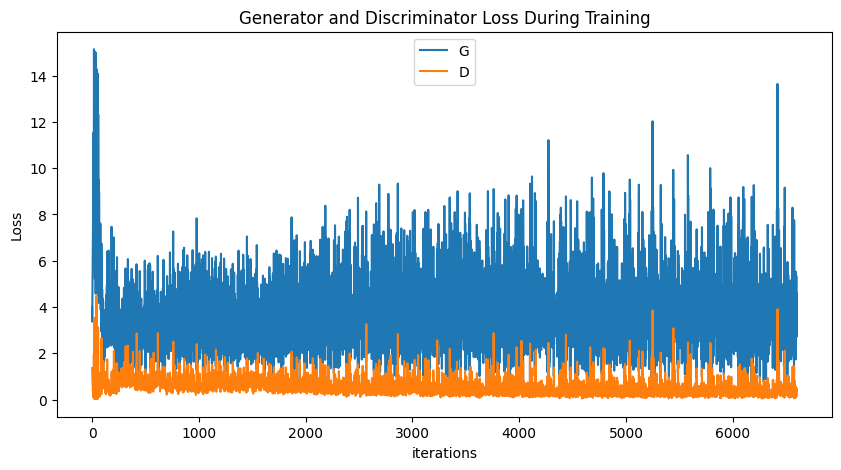

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saving Model

In [16]:
torch.save(netG.state_dict(), "../weights/generator.pth")
torch.save(netD.state_dict(), "../weights/discriminator.pth")

## Generating New Images

In [1]:
import torch
import matplotlib.pyplot as plt

In [8]:
generator_weights = torch.load("../weights/generator.pth")
discriminator_weights = torch.load("../weights/discriminator.pth")

netG.load_state_dict(generator_weights)
netD.load_state_dict(discriminator_weights)

<All keys matched successfully>

In [9]:
def generate_image(generator, device):
    generator.eval()
    noise = torch.randn(1, 100, 1, 1, device=device)

    with torch.no_grad():
        fake_image = generator(noise).detach().cpu()
        
    fake_image = fake_image / 2 + 0.5  # Denormalize
    np_image = fake_image.squeeze().numpy().transpose(1, 2, 0)
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

In [10]:
def generate_images_grid(generator, device, num_images=20, grid_size=(4, 5)):
    generator.eval()
    
    # Generate a batch of latent vectors
    noise = torch.randn((num_images, 100, 1, 1), device=device)
    
    # Generate fake images
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
    
    # Denormalize the images
    fake_images = fake_images / 2 + 0.5  # Denormalize
    
    # Create a grid of images
    fig, axes = plt.subplots(*grid_size, figsize=(grid_size[1] * 2, grid_size[0] * 2))
    for i, ax in enumerate(axes.flatten()):
        np_image = fake_images[i].numpy().transpose(1, 2, 0)
        ax.imshow(np_image)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

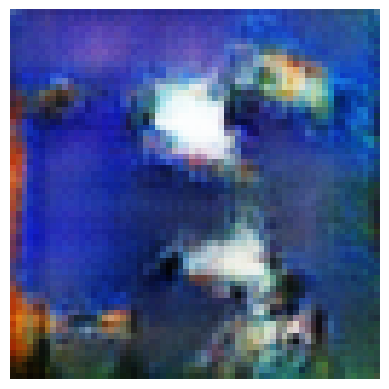

In [24]:
generate_image(netG, device)

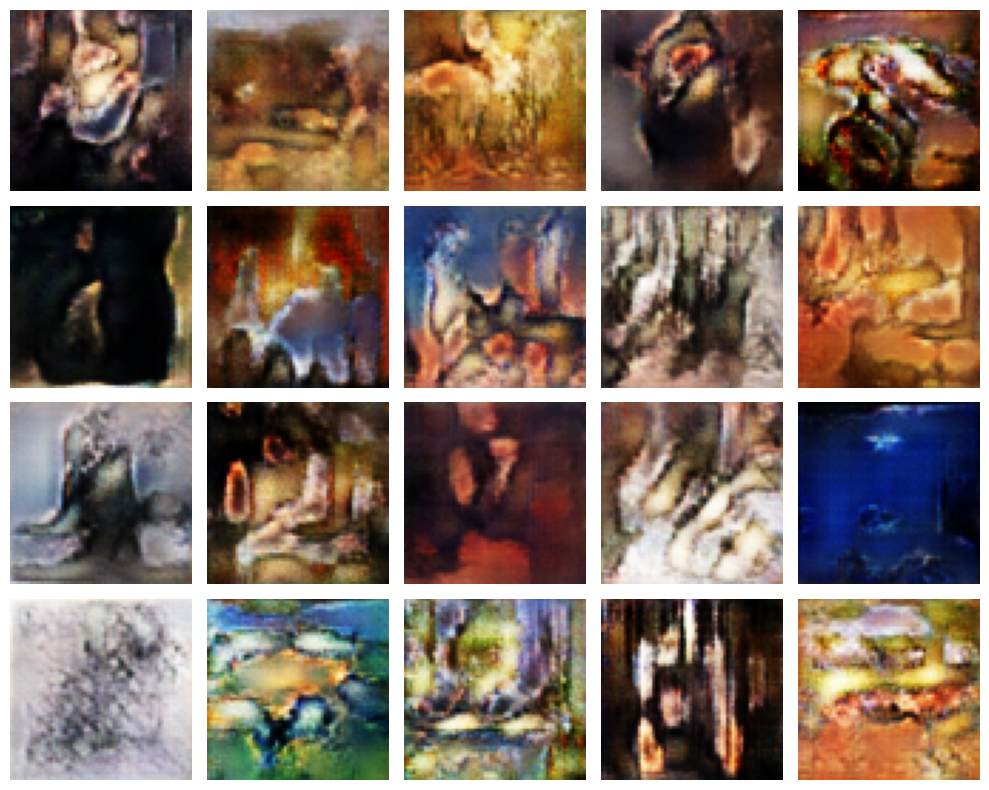

In [33]:
generate_images_grid(netG, device)